
🔢 Use these values in ESP32 code:
float a = 0.00000000;  // slope
float b = 1000.00;   // intercept



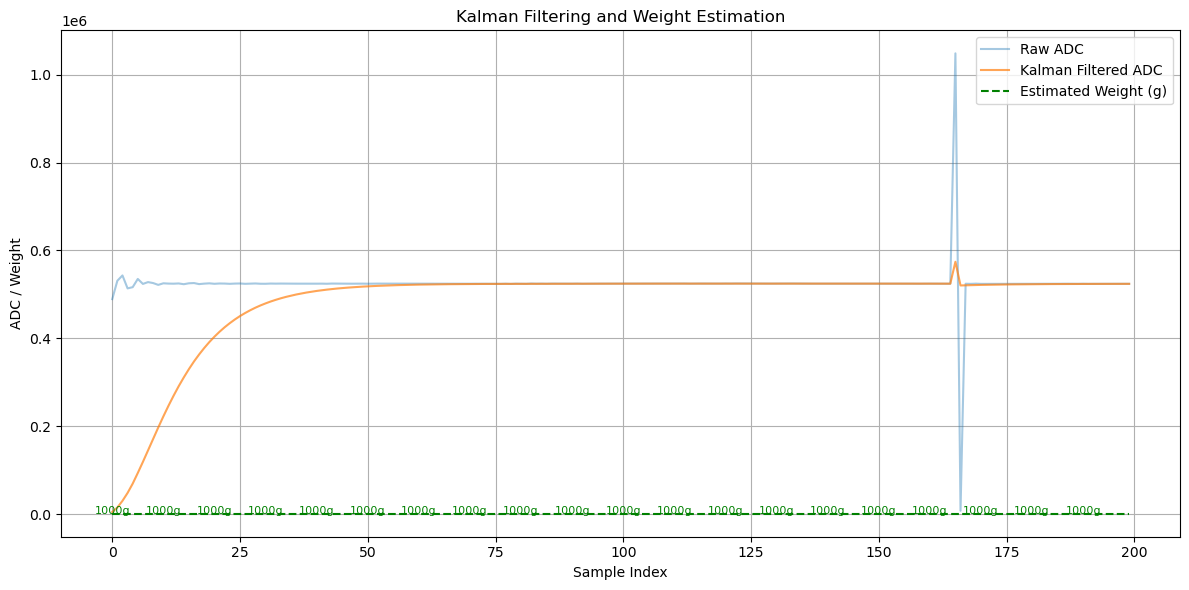

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# === Kalman Filter Class ===
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, initial_estimate=0.0, initial_error=1.0):
        self.q = process_variance
        self.r = measurement_variance
        self.x = initial_estimate
        self.p = initial_error

    def update(self, measurement):
        self.p += self.q
        k = self.p / (self.p + self.r)
        self.x += k * (measurement - self.x)
        self.p *= (1 - k)
        return self.x

# === Load CSV ===
filename = "weight_1000.csv"
df = pd.read_csv(filename)

# === Apply Kalman Filter ===
kf = KalmanFilter(process_variance=1000, measurement_variance=100000)
filtered_adc = [kf.update(x) for x in df['raw_reading']]

# === Fit Linear Model ===
X = np.array(filtered_adc).reshape(-1, 1)
y = df['true_weight_grams'].values
model = LinearRegression().fit(X, y)

a = model.coef_[0]
b = model.intercept_

print(f"\n🔢 Use these values in ESP32 code:")
print(f"float a = {a:.8f};  // slope")
print(f"float b = {b:.2f};   // intercept\n")

# === Predicted weights ===
estimated_weight = model.predict(X)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(df['raw_reading'], label='Raw ADC', alpha=0.4)
plt.plot(filtered_adc, label='Kalman Filtered ADC', alpha=0.7)
plt.plot(estimated_weight, label='Estimated Weight (g)', linestyle='--', color='green')

# Annotate every 10th sample
for i in range(0, len(estimated_weight), 10):
    plt.text(i, estimated_weight[i] + 50, f"{estimated_weight[i]:.0f}g", fontsize=8, color='green', ha='center')

plt.title('Kalman Filtering and Weight Estimation')
plt.xlabel('Sample Index')
plt.ylabel('ADC / Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



🔢 Polynomial regression (degree 2) coefficients:
float a0 = 0.00000000;
float a1 = -0.00393112;
float a2 = 0.00000001;
float intercept = 1495.56;


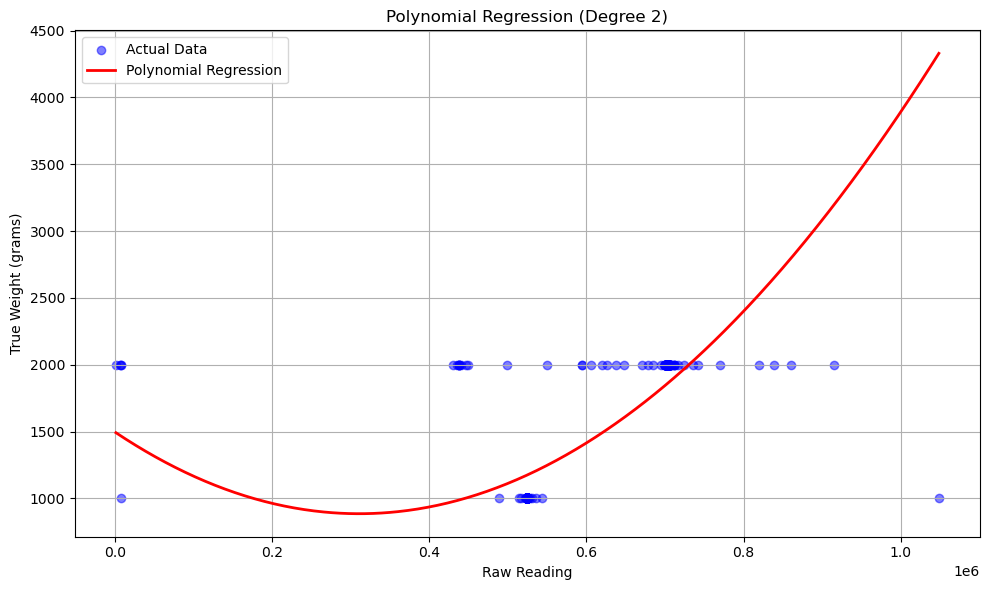

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Use raw string to avoid unicode errors
csv_directory = r'C:\Users\Zwivh\OneDrive - University of Cape Town\5th Year\EEE4113F\MCU Design\Software\Weight_Estimation_Training'

# List CSV files (e.g., weight_1000.csv, etc.)
csv_files = [f for f in os.listdir(csv_directory) if f.startswith('weight_') and f.endswith('.csv')]

all_data = []

for file in csv_files:
    file_path = os.path.join(csv_directory, file)
    
    try:
        data = pd.read_csv(file_path, header=None, names=['raw_reading', 'true_weight_grams'])

        # Drop invalid rows
        data = data[pd.to_numeric(data['raw_reading'], errors='coerce').notnull()]
        data['raw_reading'] = data['raw_reading'].astype(float)
        data['true_weight_grams'] = data['true_weight_grams'].astype(float)

        all_data.append(data)
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")

# Combine all data
df = pd.concat(all_data, ignore_index=True)

# Features and target
X = df[['raw_reading']].values
y = df['true_weight_grams'].values

# Polynomial regression model (degree 2)
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Extract coefficients for use in ESP32 code
poly = model.named_steps['polynomialfeatures']
linreg = model.named_steps['linearregression']

# Display coefficients for ESP32
coeffs = linreg.coef_
intercept = linreg.intercept_

print(f"\n🔢 Polynomial regression (degree {degree}) coefficients:")
for i, coef in enumerate(coeffs):
    print(f"float a{i} = {coef:.8f};")

print(f"float intercept = {intercept:.2f};")

# Plotting
X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred = model.predict(X_range)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Actual Data')
plt.plot(X_range, y_pred, color='red', linewidth=2, label='Polynomial Regression')
plt.xlabel('Raw Reading')
plt.ylabel('True Weight (grams)')
plt.title(f'Polynomial Regression (Degree {degree})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Polynomial model:        2
1e-08 x - 0.003931 x + 1496


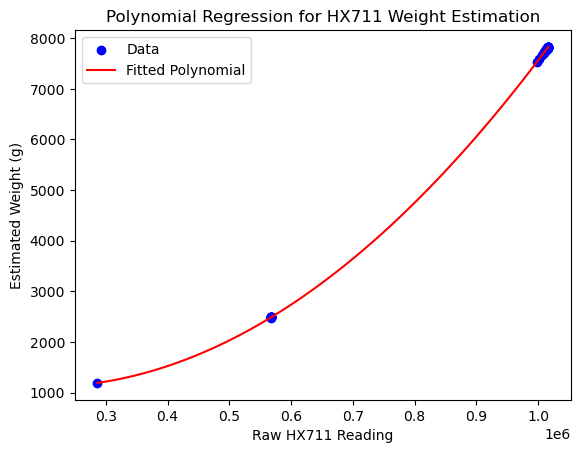

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Example Data: Raw HX711 readings and corresponding weights
raw_readings = np.array([
    567181, 567058, 567296, 567243, 567392, 567418, 567305, 567465, 567395, 567661, 567793,
    567463, 286281, 567550, 567417, 567492, 567712, 567264, 997993, 1001838, 1006525, 1008686,
    1009920, 1011242, 1012251, 1012400, 1013329, 1013690, 1013915, 1014268, 1014629, 1014720,
    1015237, 1015401, 1015563, 1015689, 1016183, 1016167, 1016282, 1016282, 1016292, 1016272,
    1016255, 1016123, 1015996, 1016048
])

weights = np.array([
    2482.85, 2481.93, 2483.70, 2483.31, 2484.41, 2484.60, 2483.77, 2484.95, 2484.43, 2486.41,
    2487.39, 2484.94, 1189.72, 2485.58, 2484.60, 2485.15, 2486.78, 2483.46, 7532.23, 7594.01,
    7669.72, 7704.77, 7724.83, 7746.35, 7762.80, 7765.23, 7780.40, 7786.30, 7789.97, 7795.75,
    7801.65, 7803.14, 7811.60, 7814.29, 7816.94, 7819.01, 7827.10, 7826.84, 7828.72, 7828.72,
    7828.89, 7828.56, 7828.28, 7826.12, 7824.04, 7824.89
])

# Fit a polynomial of degree 2
coefficients = np.polyfit(raw_readings, weights, 2)
polynomial = np.poly1d(coefficients)

# Print the polynomial equation
print(f"Polynomial model: {polynomial}")

# Plotting the data and fitted curve
plt.scatter(raw_readings, weights, color='blue', label='Data')
x_vals = np.linspace(min(raw_readings), max(raw_readings), 100)
y_vals = polynomial(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Fitted Polynomial')
plt.xlabel('Raw HX711 Reading')
plt.ylabel('Estimated Weight (g)')
plt.title('Polynomial Regression for HX711 Weight Estimation')
plt.legend()
plt.show()
